# Obesity Estimation - Feature Engineering and Machine Learning Models

### In this notebook we will implement various Machine Learning Classification alogrithms to select the best performing model
1) Decision Tree </br>
2) Random Forest</br>
3) KNN </br>
4) XGBClassifier</br>


### We will use the following steps:
##### Split the Dataset:
Split the dataset into training and test sets before applying transformations to avoid data leakage.
##### One-Hot Encoding:
Apply one-hot encoding only to the training set using fit_transform.</br>
Use the same encoder to transform the test set with transform, ensuring consistency.</br>
Handle unknown categories with handle_unknown='ignore'.
##### Label Encoding for Target Variable:
Apply label encoding to the entire target column (train + test) for consistent label mappings across splits.
This is safe as it will not allow information to leak from features to the model.
##### Feature Scaling:
Apply scaling (e.g., StandardScaler or MinMaxScaler) only to the training set using fit_transform.
Use the same scaler to transform the test set with transform.
##### Save Encoders/Scalers:
Save the fitted encoders and scalers to ensure consistent transformations for future data.

#####  GridsearchCV and 5-fold cross-validation to compare the accuracies.

In [1]:
import pandas as pd

In [2]:
# Read data and convert to a dataframe
clean_data_df = pd.read_csv(r'../data/clean_data.csv')

clean_data_df.info()

clean_data_df.drop('BMI', axis='columns', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2087 entries, 0 to 2086
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Gender                     2087 non-null   object 
 1   Age                        2087 non-null   float64
 2   Height                     2087 non-null   float64
 3   Weight                     2087 non-null   float64
 4   Family_History             2087 non-null   object 
 5   High_Cal_Foods_Frequently  2087 non-null   object 
 6   Freq_Veg                   2087 non-null   float64
 7   Num_Meals                  2087 non-null   float64
 8   Snacking                   2087 non-null   object 
 9   Smoke                      2087 non-null   object 
 10  Water_Intake               2087 non-null   float64
 11  Calorie_Monitoring         2087 non-null   object 
 12  Phys_Activity              2087 non-null   float64
 13  Tech_Use                   2087 non-null   float

In [3]:
# Feature columns by preprocessing type: categorical and continous

cat_cols = ['Gender', 'Family_History', 'High_Cal_Foods_Frequently', 'Snacking','Smoke', 'Calorie_Monitoring', 'Freq_Alcohol', 'Transportation']

num_cols = ['Age', 'Height', 'Weight', 'Freq_Veg', 'Num_Meals','Water_Intake', 'Phys_Activity', 'Tech_Use']

### Define dataframes X and y 

In [4]:
X = clean_data_df.drop('Obesity_Level',axis=1)  
y = clean_data_df['Obesity_Level'] 

X.shape, y.shape

((2087, 16), (2087,))

### Train test split - stratified splitting
Stratified splitting means that when you generate a training / validation dataset split, it will attempt to keep the same percentages of classes in each split.

These dataset divisions are usually generated randomly according to a target variable. However, when doing so, the proportions of the target variable among the different splits can differ, especially in the case of small datasets.

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1669, 16), (418, 16), (1669,), (418,))

### Scaling - OneHot for cat columns and Standard scaling for num columns

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
Sscaler = StandardScaler().set_output(transform="pandas")
# Encoding multiple columns. 
transformer = make_column_transformer((Sscaler, num_cols), (OneHotEncoder(handle_unknown='ignore'), 
     cat_cols),verbose=True,verbose_feature_names_out=True, remainder='drop')

transformer

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['Age', 'Height', 'Weight', 'Freq_Veg',
                                  'Num_Meals', 'Water_Intake', 'Phys_Activity',
                                  'Tech_Use']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Gender', 'Family_History',
                                  'High_Cal_Foods_Frequently', 'Snacking',
                                  'Smoke', 'Calorie_Monitoring', 'Freq_Alcohol',
                                  'Transportation'])],
                  verbose=True)

### X_train encoding

In [8]:
# Transforming
transformed = transformer.fit_transform(X_train)
# Transformating back
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
# One-hot encoding removed an index. Let's put it back:
transformed_df.index = X_train.index
# Joining tables
X_train = pd.concat([X_train, transformed_df], axis=1)
# Dropping old categorical columns
X_train.drop(cat_cols, axis=1, inplace=True)
# Dropping old num columns
X_train.drop(num_cols, axis=1, inplace=True)
# CHecking result
#print(X_train.head())
print(X_train.columns)
print(X_train.shape)

[ColumnTransformer]  (1 of 2) Processing standardscaler, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing onehotencoder, total=   0.0s
Index(['standardscaler__Age', 'standardscaler__Height',
       'standardscaler__Weight', 'standardscaler__Freq_Veg',
       'standardscaler__Num_Meals', 'standardscaler__Water_Intake',
       'standardscaler__Phys_Activity', 'standardscaler__Tech_Use',
       'onehotencoder__Gender_Female', 'onehotencoder__Gender_Male',
       'onehotencoder__Family_History_no', 'onehotencoder__Family_History_yes',
       'onehotencoder__High_Cal_Foods_Frequently_no',
       'onehotencoder__High_Cal_Foods_Frequently_yes',
       'onehotencoder__Snacking_Always', 'onehotencoder__Snacking_Frequently',
       'onehotencoder__Snacking_Sometimes', 'onehotencoder__Snacking_no',
       'onehotencoder__Smoke_no', 'onehotencoder__Smoke_yes',
       'onehotencoder__Calorie_Monitoring_no',
       'onehotencoder__Calorie_Monitoring_yes',
       'onehotencoder__Freq_Alcohol_A

### X_test encoding

In [9]:
# Transforming
transformed = transformer.transform(X_test)
# Transformating back
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
# One-hot encoding removed an index. Let's put it back:
transformed_df.index = X_test.index
# Joining tables
X_test = pd.concat([X_test, transformed_df], axis=1)
# Dropping old categorical columns
X_test.drop(cat_cols, axis=1, inplace=True)
# Dropping old num columns
X_test.drop(num_cols, axis=1, inplace=True)
# CHecking result
X_test.head()

,standardscaler__Age,standardscaler__Height,standardscaler__Weight,standardscaler__Freq_Veg,standardscaler__Num_Meals,standardscaler__Water_Intake,standardscaler__Phys_Activity,standardscaler__Tech_Use,onehotencoder__Gender_Female,onehotencoder__Gender_Male,...,onehotencoder__Calorie_Monitoring_yes,onehotencoder__Freq_Alcohol_Always,onehotencoder__Freq_Alcohol_Frequently,onehotencoder__Freq_Alcohol_Sometimes,onehotencoder__Freq_Alcohol_no,onehotencoder__Transportation_Automobile,onehotencoder__Transportation_Bike,onehotencoder__Transportation_Motorbike,onehotencoder__Transportation_Public_Transportation,onehotencoder__Transportation_Walking
1153,-0.690071,-1.202029,-0.537291,1.084280,1.512030,-0.000656,0.376859,0.550747,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
132,0.899810,0.736866,0.848928,1.084280,0.391801,-1.644954,1.182627,-1.095082,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1923,-0.587828,0.401573,1.579131,1.084280,0.391801,-0.334381,0.499952,0.495086,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
846,-1.165664,-1.047678,-0.831968,1.008997,-2.224232,-0.000656,-0.324357,1.117030,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1246,0.821665,1.347473,0.839435,-0.801583,0.231677,0.588066,-0.155934,1.895629,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
print(X_train.columns, X_train.shape)

Index(['standardscaler__Age', 'standardscaler__Height',
       'standardscaler__Weight', 'standardscaler__Freq_Veg',
       'standardscaler__Num_Meals', 'standardscaler__Water_Intake',
       'standardscaler__Phys_Activity', 'standardscaler__Tech_Use',
       'onehotencoder__Gender_Female', 'onehotencoder__Gender_Male',
       'onehotencoder__Family_History_no', 'onehotencoder__Family_History_yes',
       'onehotencoder__High_Cal_Foods_Frequently_no',
       'onehotencoder__High_Cal_Foods_Frequently_yes',
       'onehotencoder__Snacking_Always', 'onehotencoder__Snacking_Frequently',
       'onehotencoder__Snacking_Sometimes', 'onehotencoder__Snacking_no',
       'onehotencoder__Smoke_no', 'onehotencoder__Smoke_yes',
       'onehotencoder__Calorie_Monitoring_no',
       'onehotencoder__Calorie_Monitoring_yes',
       'onehotencoder__Freq_Alcohol_Always',
       'onehotencoder__Freq_Alcohol_Frequently',
       'onehotencoder__Freq_Alcohol_Sometimes',
       'onehotencoder__Freq_Alcohol_n

In [11]:
# Setting new feature names

X_train.columns = ['Age', 'Height', 'Weight', 'Freq_Veg', 'Num_Meals', 'Water_Intake',
       'Phys_Activity', 'Tech_Use', 'Gender_Female',
       'Gender_Male', 'Family_History_no',
       'Family_History_yes',
       'High_Cal_Foods_Frequently_no',
       'High_Cal_Foods_Frequently_yes',
       'Snacking_Always', 'Snacking_Frequently',
       'Snacking_Sometimes', 'Snacking_no',
       'Smoke_no', 'Smoke_yes',
       'Calorie_Monitoring_no',
       'Calorie_Monitoring_yes',
       'Freq_Alcohol_Always',
       'Freq_Alcohol_Frequently',
       'Freq_Alcohol_Sometimes',
       'Freq_Alcohol_no',
       'Transportation_Automobile',
       'Transportation_Bike',
       'Transportation_Motorbike',
       'Transportation_Public_Transportation',
       'Transportation_Walking']

X_test.columns = ['Age', 'Height', 'Weight', 'Freq_Veg', 'Num_Meals', 'Water_Intake',
       'Phys_Activity', 'Tech_Use', 'Gender_Female',
       'Gender_Male', 'Family_History_no',
       'Family_History_yes',
       'High_Cal_Foods_Frequently_no',
       'High_Cal_Foods_Frequently_yes',
       'Snacking_Always', 'Snacking_Frequently',
       'Snacking_Sometimes', 'Snacking_no',
       'Smoke_no', 'Smoke_yes',
       'Calorie_Monitoring_no',
       'Calorie_Monitoring_yes',
       'Freq_Alcohol_Always',
       'Freq_Alcohol_Frequently',
       'Freq_Alcohol_Sometimes',
       'Freq_Alcohol_no',
       'Transportation_Automobile',
       'Transportation_Bike',
       'Transportation_Motorbike',
       'Transportation_Public_Transportation',
       'Transportation_Walking']
# After renaming the columns

X_train.head()


,Age,Height,Weight,Freq_Veg,Num_Meals,Water_Intake,Phys_Activity,Tech_Use,Gender_Female,Gender_Male,...,Calorie_Monitoring_yes,Freq_Alcohol_Always,Freq_Alcohol_Frequently,Freq_Alcohol_Sometimes,Freq_Alcohol_no,Transportation_Automobile,Transportation_Bike,Transportation_Motorbike,Transportation_Public_Transportation,Transportation_Walking
1549,0.248290,0.705537,1.045026,-0.375885,0.391801,0.253102,0.308538,-0.452916,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1574,1.008501,-0.608067,0.505277,1.016483,-0.755149,-1.644954,0.823971,-0.073903,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1155,3.702329,0.457500,-0.078269,0.207948,0.391801,-1.403908,-0.827757,-1.095082,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
610,-0.208354,0.416482,-1.265285,-0.345947,0.391801,-0.252848,1.731352,0.245475,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
906,-0.523216,-1.012212,-0.725998,-0.801583,0.596256,1.643643,0.204484,-0.952112,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Apply Label encoder

#### Encoding y_train

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

#y_train.head(10) , y_train_encoded[0:10]




#### Encoding y_test

In [13]:
le_test = LabelEncoder()
y_test_encoded = le_test.fit_transform(y_test)
y_test.head(10) , y_test_encoded[0:10]

(1153    Overweight_Level_II
 132          Obesity_Type_I
 1923       Obesity_Type_III
 846      Overweight_Level_I
 1246         Obesity_Type_I
 1236         Obesity_Type_I
 1372         Obesity_Type_I
 1010    Overweight_Level_II
 337        Obesity_Type_III
 1524        Obesity_Type_II
 Name: Obesity_Level, dtype: object,
 array([6, 2, 4, 5, 2, 2, 2, 6, 4, 3]))

### Classifier Models 

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

##### Models in consideration - RandomForest, DecisionTree, KNN, XGBoost

In [15]:
models={'RandomForest':RandomForestClassifier(),
        'DecisionTree':DecisionTreeClassifier(),
        'KNeighbors':KNeighborsClassifier(),
        'xgbc': XGBClassifier()}

##### Models in consideration - Paramter grid

In [16]:
param_grids={'RandomForest': {
                'n_estimators': [100, 200],
                'max_depth': [None, 10, 20]},
            'DecisionTree': {
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10]
            },'KNeighbors':{
            'n_neighbors': [3, 5, 7]
        }, 'xgbc':{
            'n_estimators':[600],
            'learning_rate':[0.03],
            'objective':['multi:softmax'], 
            'verbosity':[0], 
            'nthread':[-1], 
            'random_state':[42]
        }
    }

##### Scoring for measuring model performance

In [17]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')}

##### Model Evalution

In [18]:
# %reload ../models/Models_eval.py

from sklearn.model_selection import GridSearchCV

def grid_search_cv_eval(X,Y, models, param_grid, scorings,cross_validation):

    best_models = {}
    result = {}
    for model in models:
        print(result)
        print(f"\nRunning GridSearch for {model}...")
        gsv = GridSearchCV(
            estimator=models[model],
            param_grid=param_grid[model],
            cv=cross_validation,
            scoring=scorings,
            refit='accuracy'  # Primary metric for model selection
        )
        gsv.fit(X, Y)
        best_models[model] = gsv.best_estimator_
        best_index = gsv.best_index_
        print(f'Best parameters for {model}: {gsv.best_params_}')
        print(f'Best accuracy: {gsv.cv_results_["mean_test_accuracy"][best_index]:.4f}')
        print(f'Best precision: {gsv.cv_results_["mean_test_precision"][best_index]:.4f}')
        print(f'Best recall: {gsv.cv_results_["mean_test_recall"][best_index]:.4f}')
        result[model] = {"parameter":gsv.best_params_,"accuracy":gsv.cv_results_["mean_test_accuracy"][best_index], "precision": gsv.cv_results_["mean_test_precision"][best_index],"recall": gsv.cv_results_["mean_test_recall"][best_index]}

    return best_models, result

In [19]:

best_models, result = grid_search_cv_eval(X_train, y_train_encoded, models, param_grids, scoring, cross_validation=5)
best_models, result

{}

Running GridSearch for RandomForest...
Best parameters for RandomForest: {'max_depth': 20, 'n_estimators': 200}
Best accuracy: 0.9377
Best precision: 0.9428
Best recall: 0.9377
{'RandomForest': {'parameter': {'max_depth': 20, 'n_estimators': 200}, 'accuracy': 0.9376957796119474, 'precision': 0.9428223522760961, 'recall': 0.9376957796119474}}

Running GridSearch for DecisionTree...
Best parameters for DecisionTree: {'max_depth': None, 'min_samples_split': 5}
Best accuracy: 0.9191
Best precision: 0.9206
Best recall: 0.9191
{'RandomForest': {'parameter': {'max_depth': 20, 'n_estimators': 200}, 'accuracy': 0.9376957796119474, 'precision': 0.9428223522760961, 'recall': 0.9376957796119474}, 'DecisionTree': {'parameter': {'max_depth': None, 'min_samples_split': 5}, 'accuracy': 0.9191203179227131, 'precision': 0.9205556748493355, 'recall': 0.9191203179227131}}

Running GridSearch for KNeighbors...
Best parameters for KNeighbors: {'n_neighbors': 3}
Best accuracy: 0.8388
Best precision: 0.83

({'RandomForest': RandomForestClassifier(max_depth=20, n_estimators=200),
  'DecisionTree': DecisionTreeClassifier(min_samples_split=5),
  'KNeighbors': KNeighborsClassifier(n_neighbors=3),
  'xgbc': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.03, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=600, n_jobs=None, nthread=-1,
                num_parallel_tree=None, ...)},
 {'RandomForest': {'paramete

## Confusion Matrix

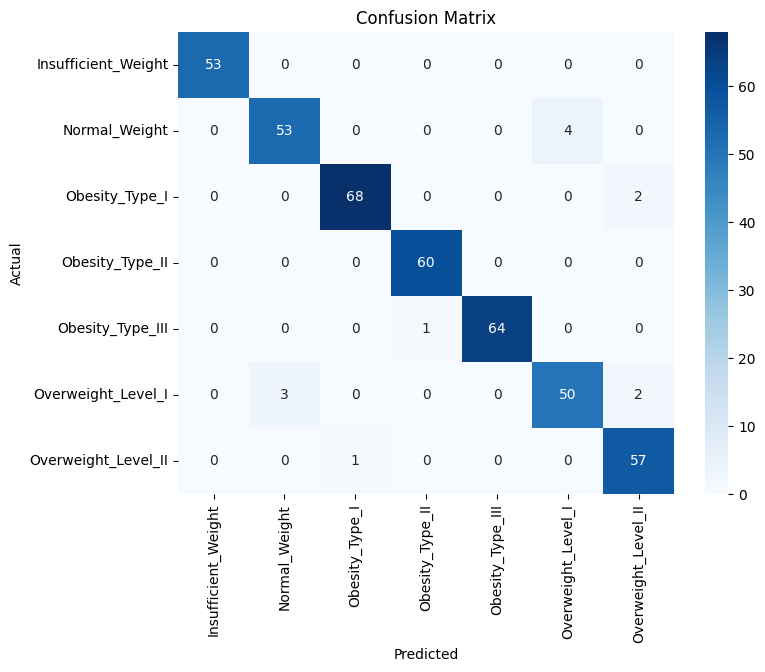

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = best_models['xgbc'].predict(X_test)

cm = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Models Performance Visuals

In [21]:
result_df = pd.DataFrame(result).T


#### Accuracy Comparison

C:\Users\Zekiye\AppData\Local\Temp\ipykernel_17404\1895503191.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result_df.index, y='accuracy', data=result_df, palette="Blues_d")


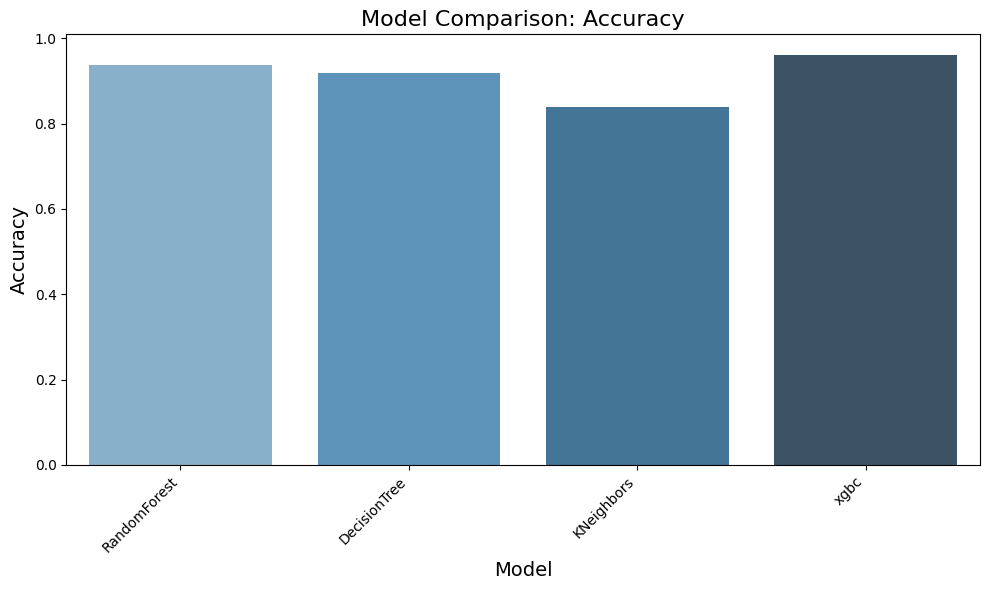

In [22]:
# Plot Accuracy
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.figure(figsize=(10, 6))
sns.barplot(x=result_df.index, y='accuracy', data=result_df, palette="Blues_d")
plt.title('Model Comparison: Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Precision Comparison

C:\Users\Zekiye\AppData\Local\Temp\ipykernel_17404\3424882693.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result_df.index, y='precision', data=result_df, palette="Greens_d")


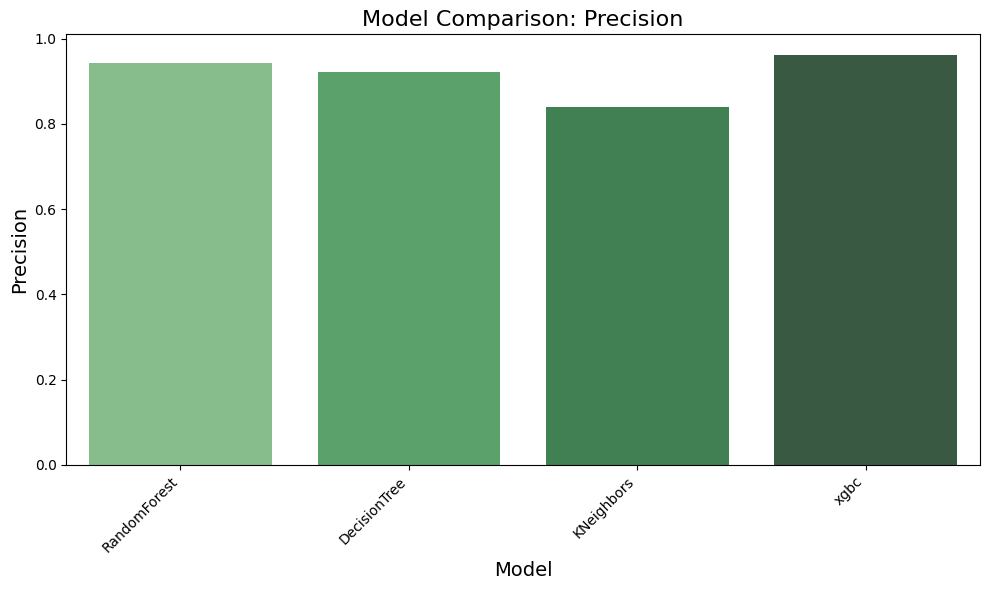

In [23]:
# Plot Precision
plt.figure(figsize=(10, 6))
sns.barplot(x=result_df.index, y='precision', data=result_df, palette="Greens_d")
plt.title('Model Comparison: Precision', fontsize=16)
plt.ylabel('Precision', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Recall Comparison

C:\Users\Zekiye\AppData\Local\Temp\ipykernel_17404\900479777.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result_df.index, y='recall', data=result_df, palette="Oranges_d")


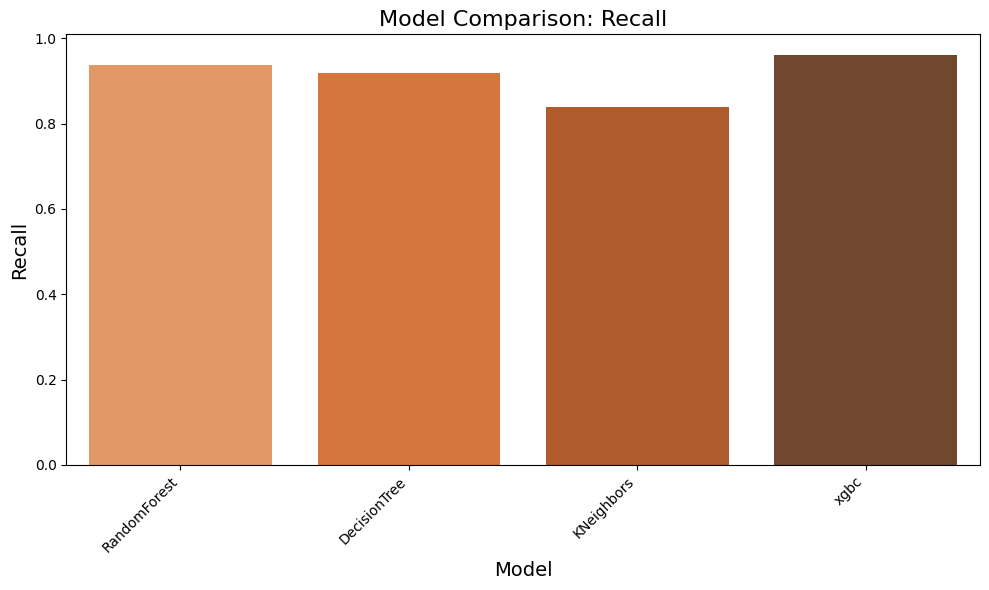

In [24]:
# Plot Precision
plt.figure(figsize=(10, 6))
sns.barplot(x=result_df.index, y='recall', data=result_df, palette="Oranges_d")
plt.title('Model Comparison: Recall', fontsize=16)
plt.ylabel('Recall', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Based on Visuals above we can clearly notice that RandomForest and XGBC models are showing good results. We will tune the parameters next to find the best suitable model

## Creating a comparison table for the Models

In [69]:
models = ['RandomForest', 'DecisionTree', 'KNeighbors', 'xgbc']

result_df['f1_score'] = 2 * (result_df['precision'] * result_df['recall']) / (result_df['precision'] + result_df['recall'])

# Display the updated table with F1 score
display(result_df)

,parameter,accuracy,precision,recall,f1_score
RandomForest,"{'max_depth': 20, 'n_estimators': 200}",0.937696,0.942822,0.937696,0.940252
DecisionTree,"{'max_depth': None, 'min_samples_split': 5}",0.91912,0.920556,0.91912,0.919837
KNeighbors,{'n_neighbors': 3},0.838836,0.838994,0.838836,0.838915
xgbc,"{'learning_rate': 0.03, 'n_estimators': 600, '...",0.961056,0.961783,0.961056,0.961419


The results highlight that the xgbc model outperforms others with the highest accuracy (96.1%), precision (96.2%), recall (96.1%), and F1 score (96.1%), demonstrating its superior ability to classify data correctly. The RandomForest model also shows strong performance, achieving an accuracy of 93.7%, making it a competitive alternative. In comparison, the DecisionTree model and KNeighbors model perform slightly lower, with accuracies of 92.2% and 83.9%, respectively. Based on these findings, we have decided to conduct further comparisons between RandomForest and XGBoost to refine our model selection process.

#### Hyper tuning the two best models - Random Forest and XGBC

In [26]:
models={'RandomForest_hyper_tuned':RandomForestClassifier(),
        'xgbc_hyper_tuned': XGBClassifier()}

In [27]:
param_grids={'RandomForest_hyper_tuned': {
                'n_estimators': [50, 100, 200, 400],
                'max_depth': [None, 10, 20]},
             'xgbc_hyper_tuned':{
            'n_estimators':[50, 100, 200, 400],
            'learning_rate':[0.001, 0.01, 0.03, 0.3],
            'objective':['multi:softmax'],
            'verbosity':[0],
            'nthread':[-1],
            'random_state':[42]}
    }

In [28]:
best_models_hyper_tuned, result_hyper_tuned = grid_search_cv_eval(X_train, y_train_encoded, models, param_grids, scoring, cross_validation=5)
best_models_hyper_tuned, result_hyper_tuned

{}

Running GridSearch for RandomForest_hyper_tuned...
Best parameters for RandomForest_hyper_tuned: {'max_depth': 20, 'n_estimators': 100}
Best accuracy: 0.9359
Best precision: 0.9405
Best recall: 0.9359
{'RandomForest_hyper_tuned': {'parameter': {'max_depth': 20, 'n_estimators': 100}, 'accuracy': 0.9358957760155364, 'precision': 0.9404681311592384, 'recall': 0.9358957760155364}}

Running GridSearch for xgbc_hyper_tuned...
Best parameters for xgbc_hyper_tuned: {'learning_rate': 0.3, 'n_estimators': 200, 'nthread': -1, 'objective': 'multi:softmax', 'random_state': 42, 'verbosity': 0}
Best accuracy: 0.9635
Best precision: 0.9641
Best recall: 0.9635


({'RandomForest_hyper_tuned': RandomForestClassifier(max_depth=20),
  'xgbc_hyper_tuned': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.3, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=200, n_jobs=None, nthread=-1,
                num_parallel_tree=None, ...)},
 {'RandomForest_hyper_tuned': {'parameter': {'max_depth': 20,
    'n_estimators': 100},
   'accuracy': 0.9358957760155364,
   'precision': 

### Feature Importance

C:\Users\Zekiye\AppData\Local\Temp\ipykernel_17404\2094430465.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=fimp.index, x=fimp.values, palette=palette, orient='h')
C:\Users\Zekiye\AppData\Local\Temp\ipykernel_17404\2094430465.py:16: UserWarning: 
The palette list has fewer values (4) than needed (31) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(y=fimp.index, x=fimp.values, palette=palette, orient='h')


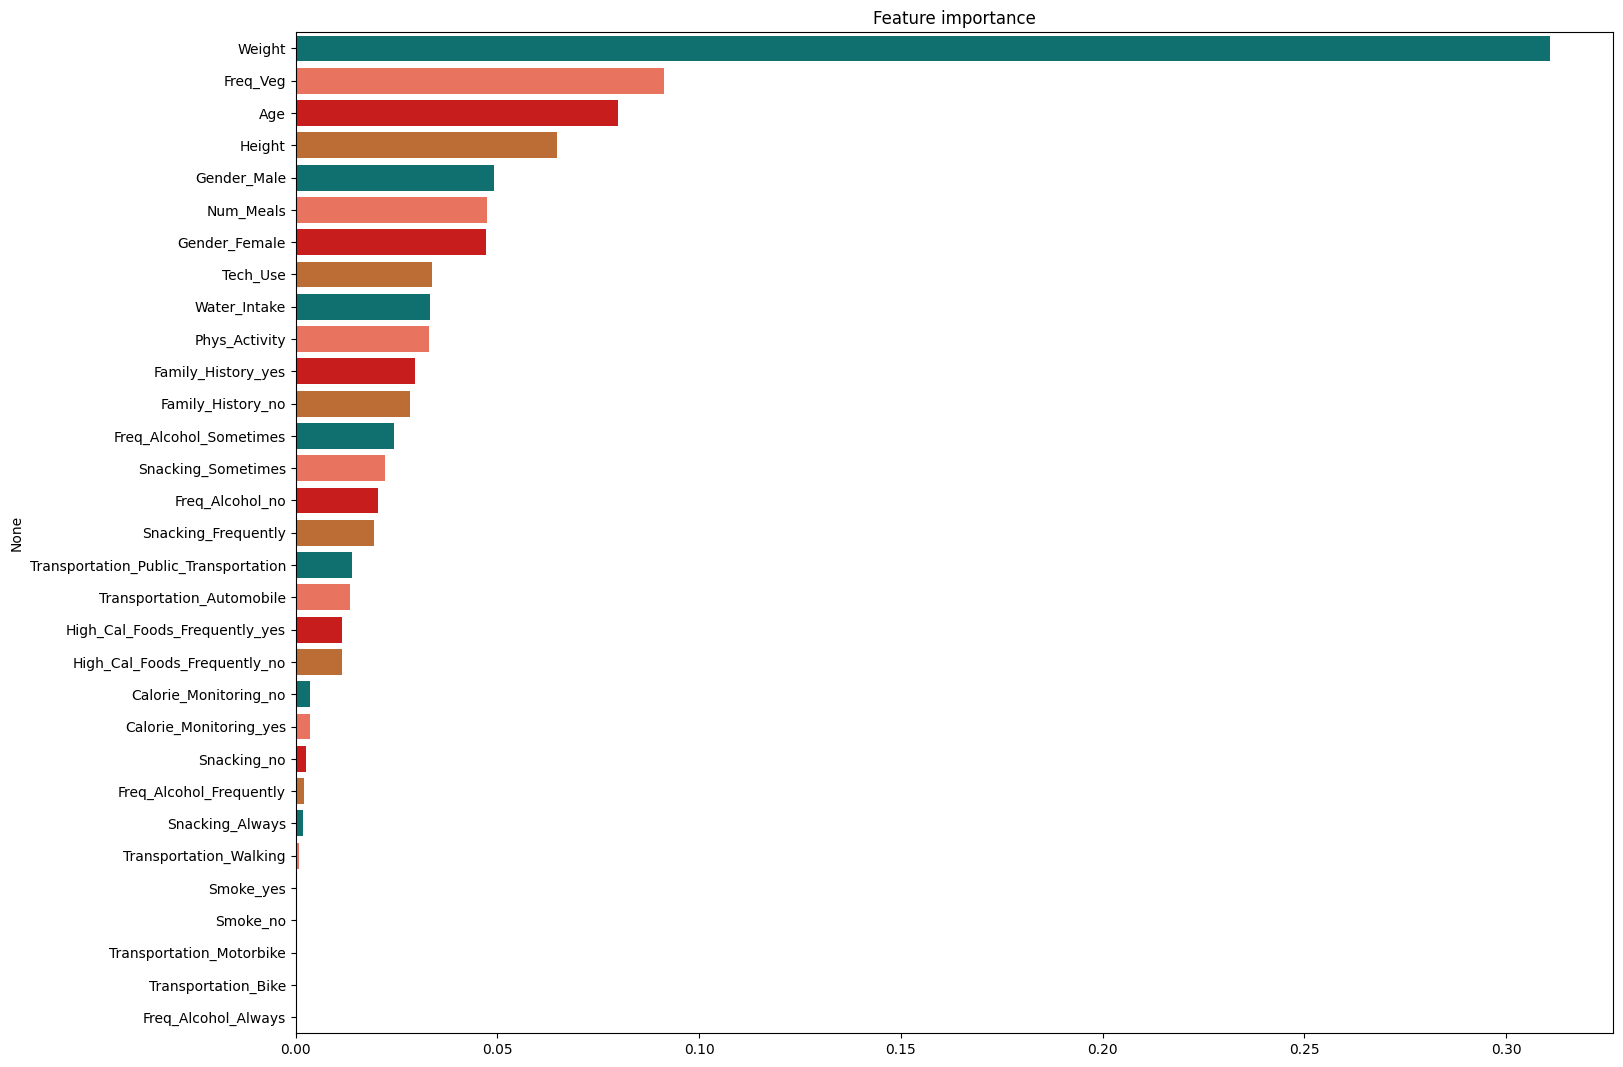

In [29]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import plotly.express as px

from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

palette = ['#008080','#FF6347', '#E50000', '#D2691E'] # Creating color palette for plots

clf = RandomForestClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=5000, random_state=13)
clf = clf.fit(X_train, y_train)

fimp = pd.Series(data=clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(17,13))
plt.title("Feature importance")
ax = sns.barplot(y=fimp.index, x=fimp.values, palette=palette, orient='h')

#### Classic feature attributions
Here we try out the global feature importance calcuations that come with XGBoost. 

In [30]:
xgboot_model = best_models_hyper_tuned.get('xgbc_hyper_tuned')
xgboot_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, nthread=-1,
              num_parallel_tree=None, ...)

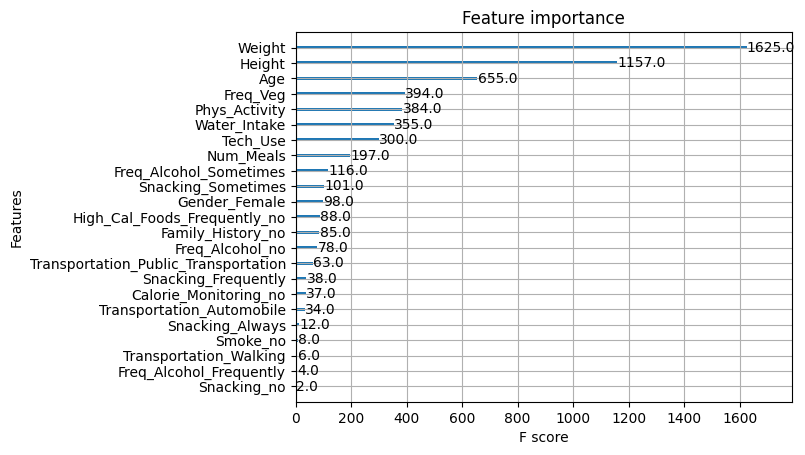

In [31]:
import xgboost
xgboost.plot_importance(xgboot_model)
#plt.title("xgboost plot_importance(model)")
plt.show()

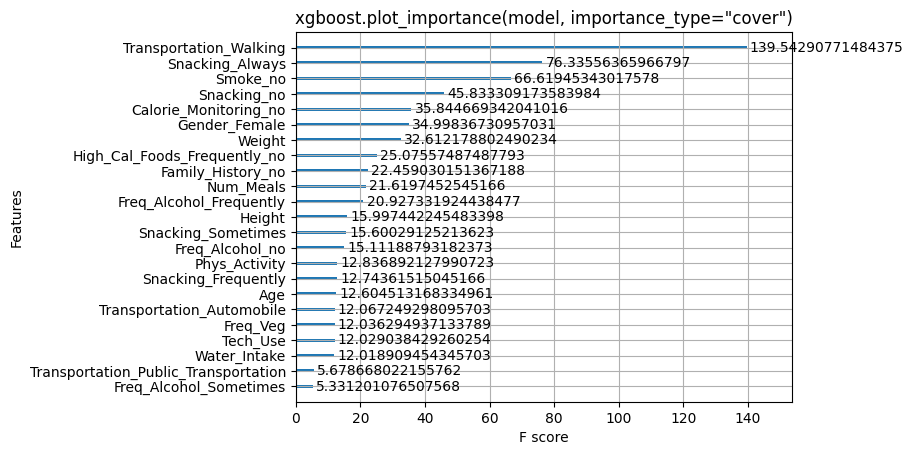

In [32]:
xgboost.plot_importance(xgboot_model, importance_type="cover")
plt.title('xgboost.plot_importance(model, importance_type="cover")')
plt.show()

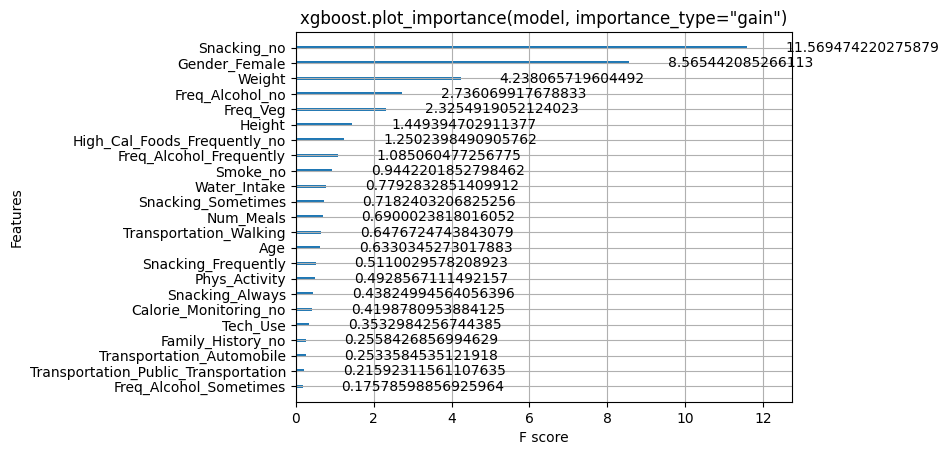

In [33]:
xgboost.plot_importance(xgboot_model, importance_type="gain")
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()

### SHAP Explainibity

In [181]:
### code here

import shap

# print the JS visualization code to the notebook
shap.initjs()

In [182]:
explainer = shap.TreeExplainer(xgboot_model)
shap_values = explainer.shap_values(X_train)

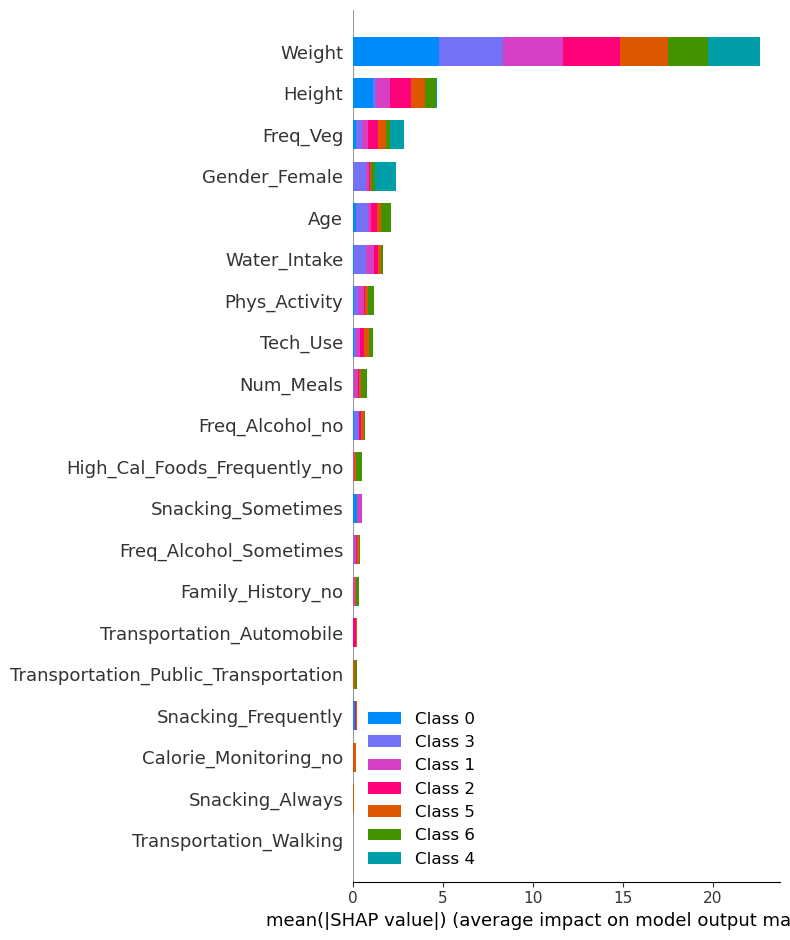

In [183]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [40]:
class_mapping = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}


In this above plot here are the key outputs;

**Top Features:**

- Weight is the most dominant feature, influencing predictions for all classes substantially.
- Height and Freq_Veg also have strong impacts across multiple classes.

**Lower Features:**

- Features like Transportation_Walking, Snacking_Always, and Calorie_Monitoring_no contribute very little to    predictions and may not add significant predictive power.

**Class-Specific Feature Importance:**

Features like Weight and Height have significant contributions to multiple classes (e.g., Class 0 (insuffcient weight) and Class 4- Obesity_Type 1).
Some features may contribute more selectively to certain classes (e.g., Transportation_Public_Transportation is minimal overall but may still have some relevance for a specific class).

Overall all classes look like a similar contribution.

## Feature Engineering

Here I will remove the height and weight from the dataset to clearly give indications which parameter has the main effect on the obesity. After Now I will train the XGBoost one more time with new dataset.

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Drop Weight and Height
dataset_cleaned = clean_data_df.drop(columns=['Weight', 'Height'])

#  Separate features and target variable
X_new = dataset_cleaned.drop(columns=['Obesity_Level'])
y_new = dataset_cleaned['Obesity_Level']

In [42]:
# Encode categorical target variable
le = LabelEncoder()
y_encoded_new = le.fit_transform(y)

In [43]:
# Split data into training and testing sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_encoded_new, stratify=y_encoded_new, test_size=0.2, random_state=42)


In [44]:
# One-Hot Encode Categorical Features
categorical_features = ['Gender', 'Family_History', 'High_Cal_Foods_Frequently', 'Snacking', 
                        'Smoke', 'Calorie_Monitoring', 'Freq_Alcohol', 'Transportation']
X_train_new = pd.get_dummies(X_train_new, columns=categorical_features, drop_first=True)
X_test_new = pd.get_dummies(X_test_new, columns=categorical_features, drop_first=True)

# Ensure train and test datasets have the same columns
X_test_new = X_test_new.reindex(columns=X_train_new.columns, fill_value=0)

# Step 2: Apply Min-Max Scaling to Numerical Features
num_cols = ['Age', 'Freq_Veg', 'Num_Meals', 'Water_Intake', 'Phys_Activity', 'Tech_Use']
scaler = MinMaxScaler()

X_train_new[num_cols] = scaler.fit_transform(X_train_new[num_cols])
X_test_new[num_cols] = scaler.transform(X_test_new[num_cols])


In [45]:
xgb_params = {
    'learning_rate': 0.3,
    'n_estimators': 200,
    'nthread': -1,
    'objective': 'multi:softmax',
    'random_state': 42,
    'verbosity': 0
}


In [46]:
xgb_model = XGBClassifier(xgb_params)
xgb_model.fit(X_train_new, y_train_new)

c:\Users\Zekiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [47]:
# Step 7: Predictions and Performance Metrics
y_pred = xgb_model.predict(X_test_new)
accuracy = accuracy_score(y_test_new, y_pred)
precision = precision_score(y_test_new, y_pred, average='weighted')
recall = recall_score(y_test_new, y_pred, average='weighted')
f1 = f1_score(y_test_new, y_pred, average='weighted')

# Display results
xgb_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}
xgb_metrics

{'Accuracy': 0.8301435406698564,
 'Precision': 0.8304352450360551,
 'Recall': 0.8301435406698564,
 'F1 Score': 0.8293002130561791}

#### All performance metrics dropped as expected but at least know we have a real persepective of real cause of the obersity levels.

Let's also try the Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

# Step 1: Train Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1  # Utilize all available cores
)
rf_model.fit(X_train_new, y_train_new)

# Step 2: Predictions and Performance Metrics
y_pred_rf = rf_model.predict(X_test_new)
rf_accuracy = accuracy_score(y_test_new, y_pred_rf)
rf_precision = precision_score(y_test_new, y_pred_rf, average='weighted')
rf_recall = recall_score(y_test_new, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_test_new, y_pred_rf, average='weighted')

# Display Random Forest Metrics and Feature Importance
rf_metrics = {
    'Accuracy': rf_accuracy,
    'Precision': rf_precision,
    'Recall': rf_recall,
    'F1 Score': rf_f1
}

rf_metrics


{'Accuracy': 0.8421052631578947,
 'Precision': 0.8440826038703797,
 'Recall': 0.8421052631578947,
 'F1 Score': 0.841514978601393}

Comparison of XGBoost and Random Forest with their performance metrics

In [65]:
# Combine metrics into a DataFrame for comparison which exclude Weight and Height
comparison_df = pd.DataFrame([rf_metrics, xgb_metrics], index=['Random Forest_EWH', 'XGBoost_EWH'])

# Display the comparison table
comparison_df

,Accuracy,Precision,Recall,F1 Score
Random Forest_EWH,0.842105,0.844083,0.842105,0.841515
XGBoost_EWH,0.830144,0.830435,0.830144,0.829300


From this comparison, we observe that the Random Forest model demonstrates better performance. Therefore, we will proceed with using the Random Forest model's output for feature selection.

## Feature Importance with using Random Forest, XGBoost and SHAP

In [50]:
# Compute Random Forest feature importance
rf_feature_importance = rf_model.feature_importances_

# Create a DataFrame for feature importance
rf_feature_importance_df = pd.DataFrame({
    'Feature': X_train_new.columns,
    'Importance': rf_feature_importance
}).sort_values(by='Importance', ascending=False)

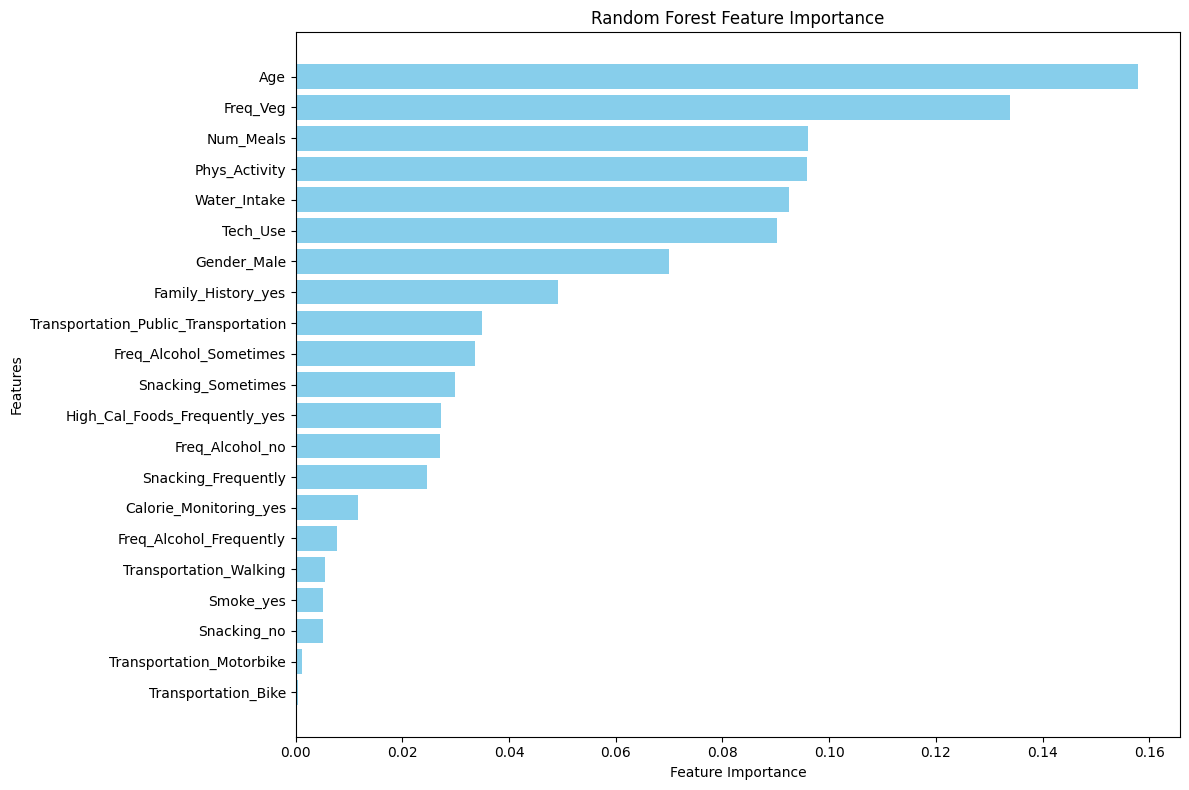

In [51]:
# Sort the feature importances for better visualization
rf_feature_importance_df = rf_feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 8))
plt.barh(rf_feature_importance_df['Feature'], rf_feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

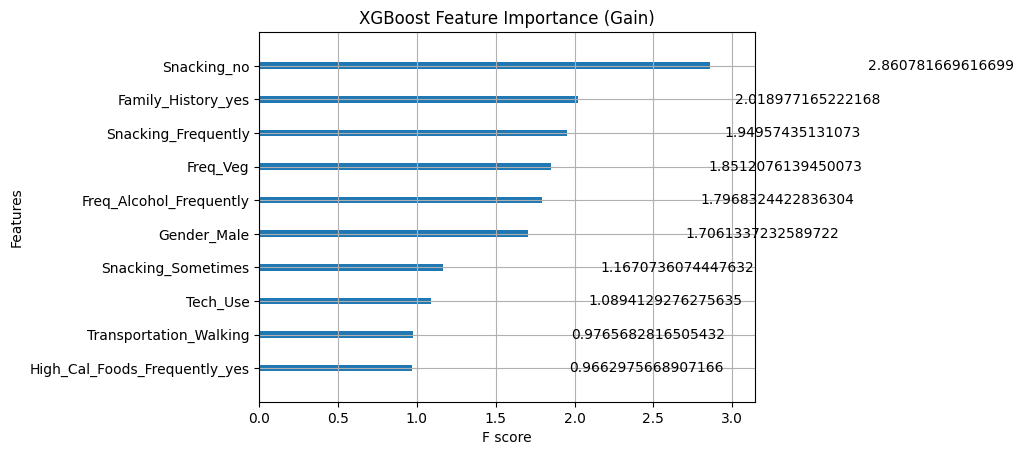

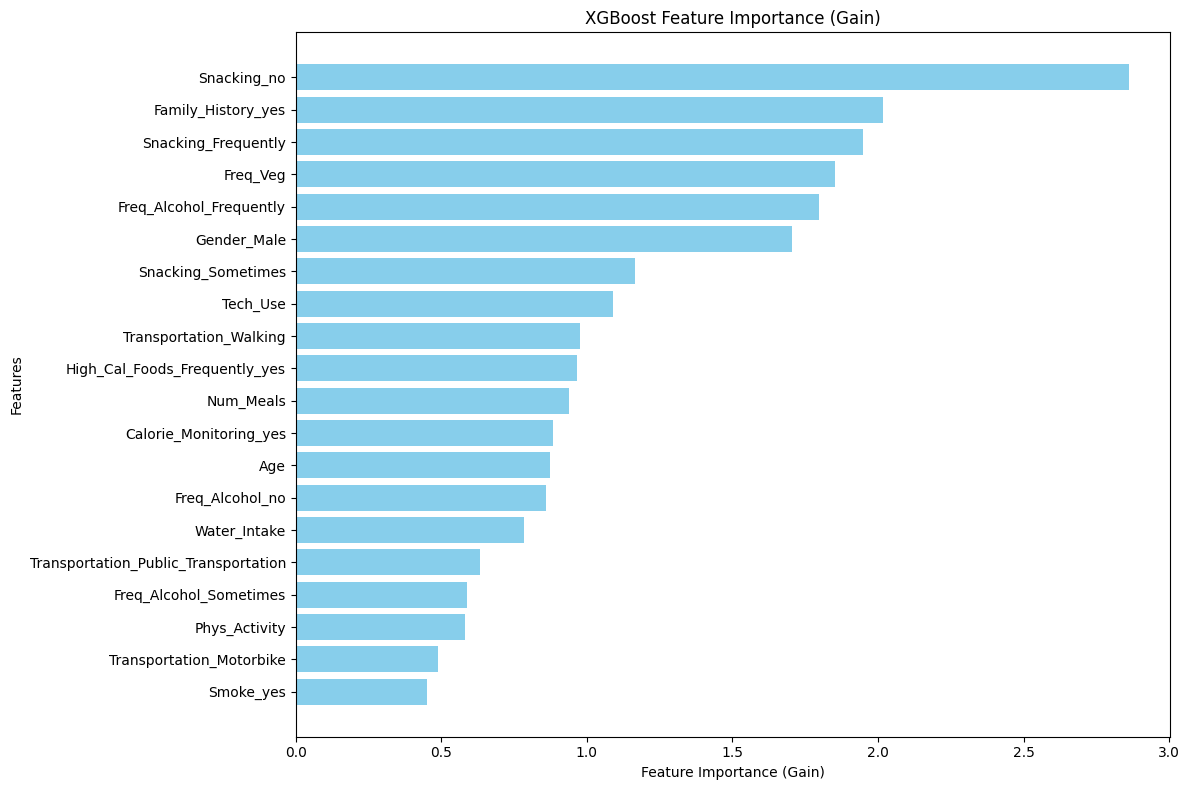

In [52]:
from xgboost import plot_importance

# Built-in plot with 'gain'
plt.figure(figsize=(12, 8))
plot_importance(xgb_model, importance_type='gain', max_num_features=10)
plt.title('XGBoost Feature Importance (Gain)')
plt.show()

# Custom plot with 'gain'
feature_importance = xgb_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance (Gain)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [203]:

# SHAP for Random Forest
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_train_new)

# SHAP for XGBoost
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_train_new)


## SHAP Values for Multi-Class Classification

Refer: https://medium.com/biased-algorithms/shap-values-for-multiclass-classification-2a1b93f69c63

Since we have a multi class classification single SHAP explanation is not enough to understand the model better. With referring the Medium post above we will implement the SHAP Values for each indiviual class to udnerstand better the feature importance.

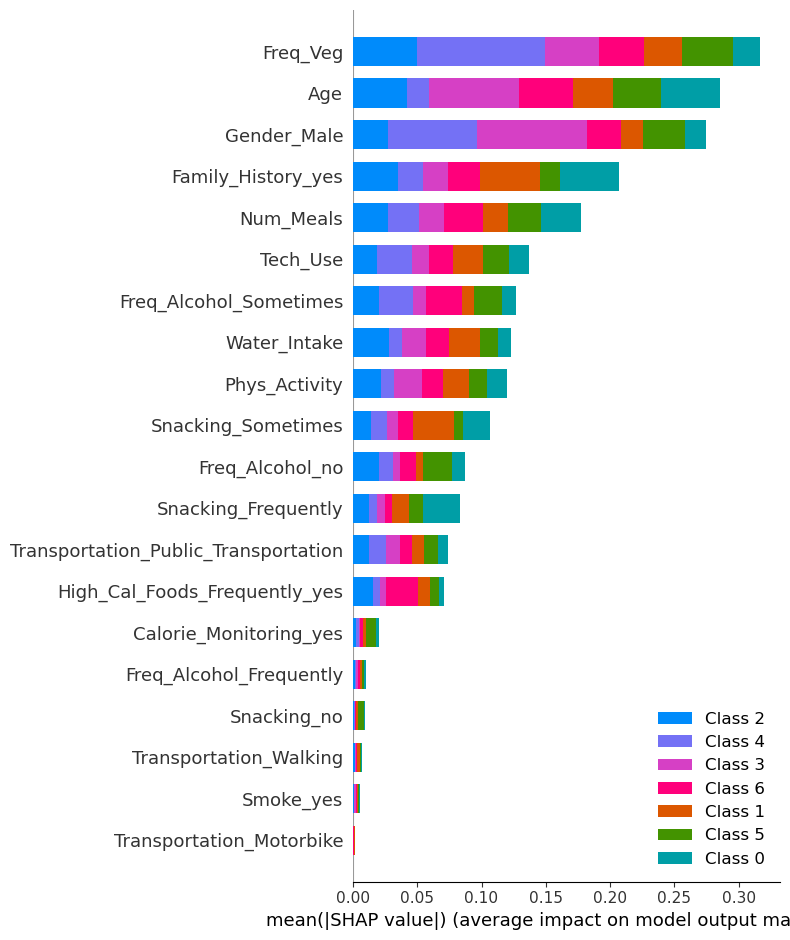

In [204]:
# Visualize the SHAP Summary Plot for RF

shap.summary_plot(shap_values_rf, X_train_new, plot_type="bar")


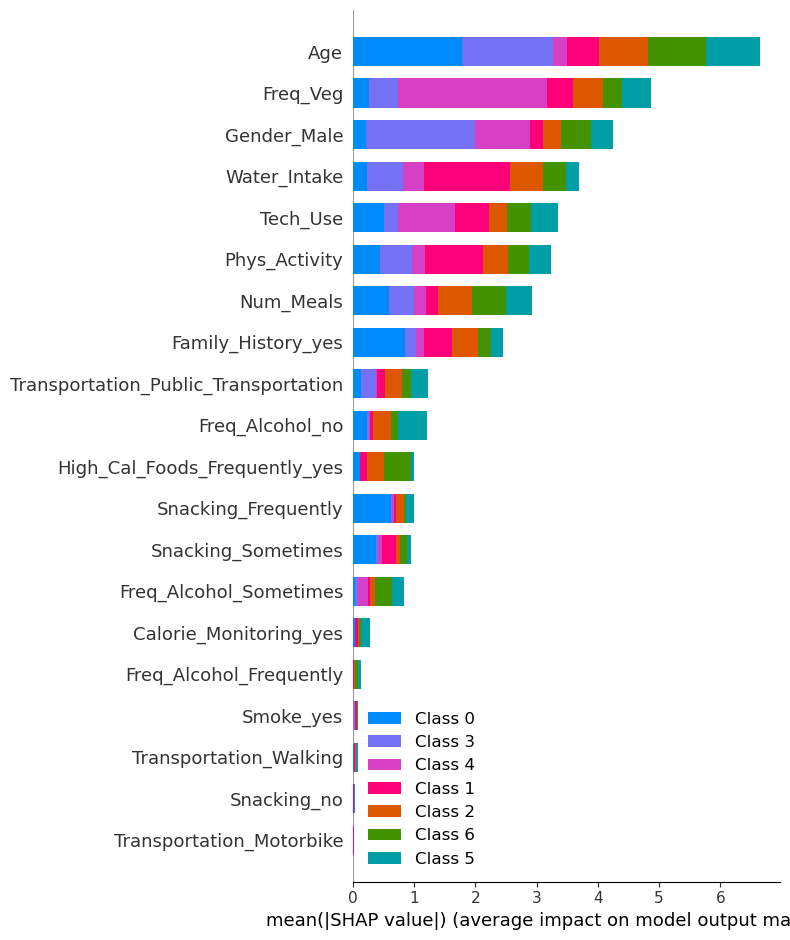

In [206]:
import xgboost as xgb

# Create DMatrix
dtrain = xgb.DMatrix(X_train_new, label=y_train_new)
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(dtrain)

#the summary plot
shap.summary_plot(shap_values_xgb, X_train_new, plot_type="bar")


## Key outputs from multi-class SHAP visualitions.

### Class-wise Feature Contributions

#### Class 0 (Insufficient Weight)
**Top contributing features:**
- **Age**: Significant impact for Class 0 (blue bar is prominent for this feature).
- **Freq_Veg**: Positive contribution, showing a noticeable influence on predictions for this class.
- **Water_Intake**: Moderate contribution, likely affecting predictions toward Class 0.

#### Class 1 (Normal Weight)
**Top contributing features:**
- **Freq_Veg**: Strong influence on predictions for Class 1 (pink bar is prominent).
- **Age**: Also contributes notably to predictions for this class.
- **Gender_Male**: Adds some effect, as seen by the visible pink bar for Class 1.

#### Class 2 (Overweight Level I)
**Top contributing features:**
- **Age**: Strong effect, indicated by a visible green bar for this class.
- **Gender_Male**: Noticeable contribution to Class 2 predictions.
- **Freq_Veg**: Moderately affects predictions.

#### Class 3 (Overweight Level II)
**Top contributing features:**
- **Age**: Significant contribution for Class 3 (orange bar is prominent).
- **Gender_Male**: Adds noticeable effect to Class 3 predictions.
- **Freq_Veg**: Also contributes moderately.

#### Class 4 (Obesity Type I)
**Top contributing features:**
- **Age**: The strongest feature for this class, with a visible purple bar.
- **Water_Intake**: Moderate influence for Class 4 predictions.
- **Gender_Male**: Somewhat affects predictions for Class 4.

#### Class 5 (Obesity Type II)
**Top contributing features:**
- **Age**: Significant effect, shown by a brown bar for this class.
- **Tech_Use**: Noticeable contribution to Class 5 predictions.
- **Freq_Veg**: Moderate influence for this class.

#### Class 6 (Obesity Type III)
**Top contributing features:**
- **Age**: Strongest influence, indicated by a teal bar.
- **Freq_Veg**: Noticeable contribution to Class 6 predictions.
- **Water_Intake**: Adds a moderate effect.


## Feature Selection
In this section, I will select some of the key features and rerun the code using the selected features to make a comparison. From the previous SHAP visualizations, we observed that the top contributors are 
- Age, 
- Frequency of Vegetables (Freq_Veg), 
- Gender, 
- Water Intake, 
- Physical Activity, 
- Tech Use,
- Number of Meals (Num_Meals), 
- Family History (Yes).

In [55]:
# Select the specified features
selected_features = ['Age', 'Freq_Veg', 'Gender_Male', 'Water_Intake', 'Phys_Activity', 'Tech_Use', 'Num_Meals', 'Family_History_yes']

X_train_selected = X_train_new[selected_features]
X_test_selected = X_test_new[selected_features]

# Initialize and train the RandomForestClassifier with selected features
rf_selected = RandomForestClassifier(n_estimators=200, max_depth=20)  # Using the best parameters found earlier.
rf_selected.fit(X_train_selected, y_train_encoded)

# Make predictions on the test set
y_pred_selected = rf_selected.predict(X_test_selected)

# Evaluate the model (example: accuracy)
from sklearn.metrics import accuracy_score
accuracy_selected = accuracy_score(y_test_encoded, y_pred_selected)
precision_selected = precision_score(y_test_encoded, y_pred_selected, average='weighted')
recall_selected = recall_score(y_test_encoded, y_pred_selected, average='weighted')
f1_selected = f1_score(y_test_encoded, y_pred_selected, average='weighted')
print(f"Accuracy with selected features: {accuracy_selected}")

# Display Random Forest Metrics and Feature Importance
rf_metrics_selected = {
    'Accuracy': accuracy_selected,
    'Precision': precision_selected,
    'Recall': recall_selected,
    'F1 Score': f1_selected
}

rf_metrics_selected 

Accuracy with selected features: 0.8110047846889952


{'Accuracy': 0.8110047846889952,
 'Precision': 0.809870888844261,
 'Recall': 0.8110047846889952,
 'F1 Score': 0.808236274579665}

### Comparasion of Baseline Random Forest Model vs Selected features Model

In [56]:
# Combine metrics into a DataFrame for comparison
comparison_models = pd.DataFrame([rf_metrics, rf_metrics_selected], index=['Random Forest Baseline', 'Random Forest Selected'])

# Display the comparison table
comparison_models

,Accuracy,Precision,Recall,F1 Score
Random Forest Baseline,0.842105,0.844083,0.842105,0.841515
Random Forest Selected,0.811005,0.809871,0.811005,0.808236


From the above table, we can observe that using the selected 8 features, compared to the model with all 14 features (excluding Weight and Height), results in only a slight difference in performance. This indicates that the reduced feature set can provide similar predictive power while simplifying the model.

### Big Comparison: Whole Feature Set vs. Excluding Weight and Height vs. Selected Features

In [77]:
result_df

,parameter,accuracy,precision,recall,f1_score
RandomForest,"{'max_depth': 20, 'n_estimators': 200}",0.937696,0.942822,0.937696,0.940252
DecisionTree,"{'max_depth': None, 'min_samples_split': 5}",0.91912,0.920556,0.91912,0.919837
KNeighbors,{'n_neighbors': 3},0.838836,0.838994,0.838836,0.838915
xgbc,"{'learning_rate': 0.03, 'n_estimators': 600, '...",0.961056,0.961783,0.961056,0.961419


In [80]:
result_comp= result_df.drop(columns=['parameter'])
result_comp = result_comp.rename(columns={
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'f1_score': 'F1 Score'
})

In [83]:
# Combine the two DataFrames row-wise
combined_df = pd.concat([ result_comp, comparison_df, comparison_models], axis=0)

# Print the combined DataFrame
print(combined_df)

                        Accuracy Precision    Recall  F1 Score
RandomForest            0.937696  0.942822  0.937696  0.940252
DecisionTree             0.91912  0.920556   0.91912  0.919837
KNeighbors              0.838836  0.838994  0.838836  0.838915
xgbc                    0.961056  0.961783  0.961056  0.961419
Random Forest_EWH       0.842105  0.844083  0.842105  0.841515
XGBoost_EWH             0.830144  0.830435  0.830144    0.8293
Random Forest Baseline  0.842105  0.844083  0.842105  0.841515
Random Forest Selected  0.811005  0.809871  0.811005  0.808236


In [87]:

# Create the DataFrame
data = {
    'Model': [
        'RandomForest', 'DecisionTree', 'KNeighbors', 'xgbc',
        'Random Forest_EWH', 'XGBoost_EWH',
        'Random Forest Baseline', 'Random Forest Selected'
    ],
    'Accuracy': [0.937696, 0.91912, 0.838836, 0.961056, 0.842105, 0.830144, 0.842105, 0.811005],
    'Precision': [0.942822, 0.920556, 0.838994, 0.961783, 0.844083, 0.830435, 0.844083, 0.809871],
    'Recall': [0.937696, 0.91912, 0.838836, 0.961056, 0.842105, 0.830144, 0.842105, 0.811005],
    'F1 Score': [0.940252, 0.919837, 0.838915, 0.961419, 0.841515, 0.8293, 0.841515, 0.808236]
}

df = pd.DataFrame(data)

# Rename the models for clarity
df['Model'] = df['Model'].replace({
    'RandomForest': 'Random Forest all features',
    'DecisionTree': 'Decision Tree all features',
    'KNeighbors': 'KNeighbors all features',
    'xgbc': 'XGBoost all features'
})

# Sort by Accuracy in descending order
df = df.sort_values(by='Accuracy', ascending=False)

# Highlight specific rows
def highlight_rows(row):
    if row['Model'] == 'XGBoost all features':
        return ['background-color: ##FFCCCB'] * len(row)  # Gold for XGBoost all features
    elif row['Model'] == 'Random Forest_EWH':
        return ['background-color: ##FFCCCB'] * len(row)  # Light blue for Random Forest EWH
    else:
        return [''] * len(row)

# Apply highlights
styled_table = df.style.apply(highlight_rows, axis=1)

# Display the styled table
styled_table


,Model,Accuracy,Precision,Recall,F1 Score
3,XGBoost all features,0.961056,0.961783,0.961056,0.961419
0,Random Forest all features,0.937696,0.942822,0.937696,0.940252
1,Decision Tree all features,0.919120,0.920556,0.919120,0.919837
4,Random Forest_EWH,0.842105,0.844083,0.842105,0.841515
6,Random Forest Baseline,0.842105,0.844083,0.842105,0.841515
2,KNeighbors all features,0.838836,0.838994,0.838836,0.838915
5,XGBoost_EWH,0.830144,0.830435,0.830144,0.829300
7,Random Forest Selected,0.811005,0.809871,0.811005,0.808236


## Conclusion


Based on the results and observations from the above tables and SHAP visualizations, here is the overall analysis and conclusion:

---

### 1. XGBoost Performance
- **Best Overall Performance**: XGBoost (`XGBoost all features`) consistently outperformed all other models across all metrics, achieving the highest:
  - **Accuracy**: 96.1%
  - **Precision**: 96.2%
  - **Recall**: 96.1%
  - **F1 Score**: 96.1%
- **Conclusion**: XGBoost is the most robust and reliable model for this dataset when using all features. It should be considered as the primary model for deployment or further analysis.

---

### 2. Random Forest Models
#### Baseline Random Forest (`Random Forest all features`)
- Achieved strong performance, second only to XGBoost, with:
  - **Accuracy**: 93.8%
  - **Precision**: 94.3%
  - **Recall**: 93.8%
  - **F1 Score**: 94.0%
- **Conclusion**: Random Forest all features is a strong alternative to XGBoost, offering a balance between accuracy and simplicity.

#### Random Forest EWH (Excluding Weight and Height)
- While its performance dropped slightly compared to the full-feature model, it still performed reasonably well:
  - **Accuracy**: 84.2%
  - **Precision**: 84.4%
  - **Recall**: 84.2%
  - **F1 Score**: 84.2%
- **Conclusion**: Random Forest EWH indicates that `Weight` and `Height` are critical features which is expected since we are predicting obesity levels which is highly correlated with those features. We exclude them to see real impact of other features.

---

### 3. Decision Tree and K-Nearest Neighbors
#### Decision Tree
- Performed moderately well with:
  - **Accuracy**: 91.9%
  - **Precision**: 92.1%
  - **Recall**: 91.9%
  - **F1 Score**: 91.9%
- **Conclusion**: The Decision Tree is a simpler model with relatively high performance but lags behind Random Forest and XGBoost. It could be a good choice if interpretability is a priority.

#### K-Nearest Neighbors
- Showed the weakest performance with:
  - **Accuracy**: 83.9%
  - **Precision**: 83.9%
  - **Recall**: 83.9%
  - **F1 Score**: 83.9%
- **Conclusion**: K-Nearest Neighbors is not ideal for this dataset due to its lower performance compared to other models.

---

### 4. Feature Importance Analysis
- **Critical Features**:
  - SHAP visualizations revealed that `Age`, `Freq_Veg`, `Gender`, `Water Intake`, and `Physical Activity` are among the most influential features across models.

- **Conclusion**: These findings highlight the importance of these key features for accurate predictions. Models without them may lack robustness.

---

### 5. Feature Contributions to Higher Obesity Classes (Class 4, 5, 6)
- **Class 4 (`Obesity Type I`)**:
  - Top contributing features: `Weight`, `Age`, `Water Intake`.
  - These features positively influence predictions for this class, with `Weight` being the most impactful.

- **Class 5 (`Obesity Type II`)**:
  - Top contributing features: `Weight`, `Age`, and `Tech_Use`.
  - `Weight` has the strongest positive contribution, followed by `Age`.

- **Class 6 (`Obesity Type III`)**:
  - Top contributing features: `Weight`, `Age`, and `Freq_Veg`.
  - The strong influence of `Weight` and `Age` is consistent across the higher obesity classes.

**Conclusion**: `Weight` and `Age` are the dominant features contributing to the prediction of higher obesity classes. `Water Intake` and `Freq_Veg` also play a significant role in differentiating these classes.

---

### 6. Feature Subset Analysis
- Reducing the feature set to the most important features (e.g., using only 8 features as observed in the SHAP results) showed a slight performance drop compared to using all features, but the reduction simplifies the model significantly.
- **Conclusion**: A reduced feature set can be a viable option for faster inference and simpler deployment without substantial loss of accuracy.

---

### Final Recommendation
1. **Best Model**: Deploy the `XGBoost all features` model for the highest accuracy and performance.
2. **Alternative Model**: Use `Random Forest all features` if interpretability and slightly simpler training processes are preferred.
3. **Feature Optimization**: Ensure the inclusion of key features such as `Weight`, `Height`, `Age`, and `Freq_Veg`. Avoid removing these features unless computational or data collection constraints require it.
4. **Future Considerations**: Conduct further experiments to fine-tune XGBoost hyperparameters and evaluate its performance on unseen test data or under real-world conditions.



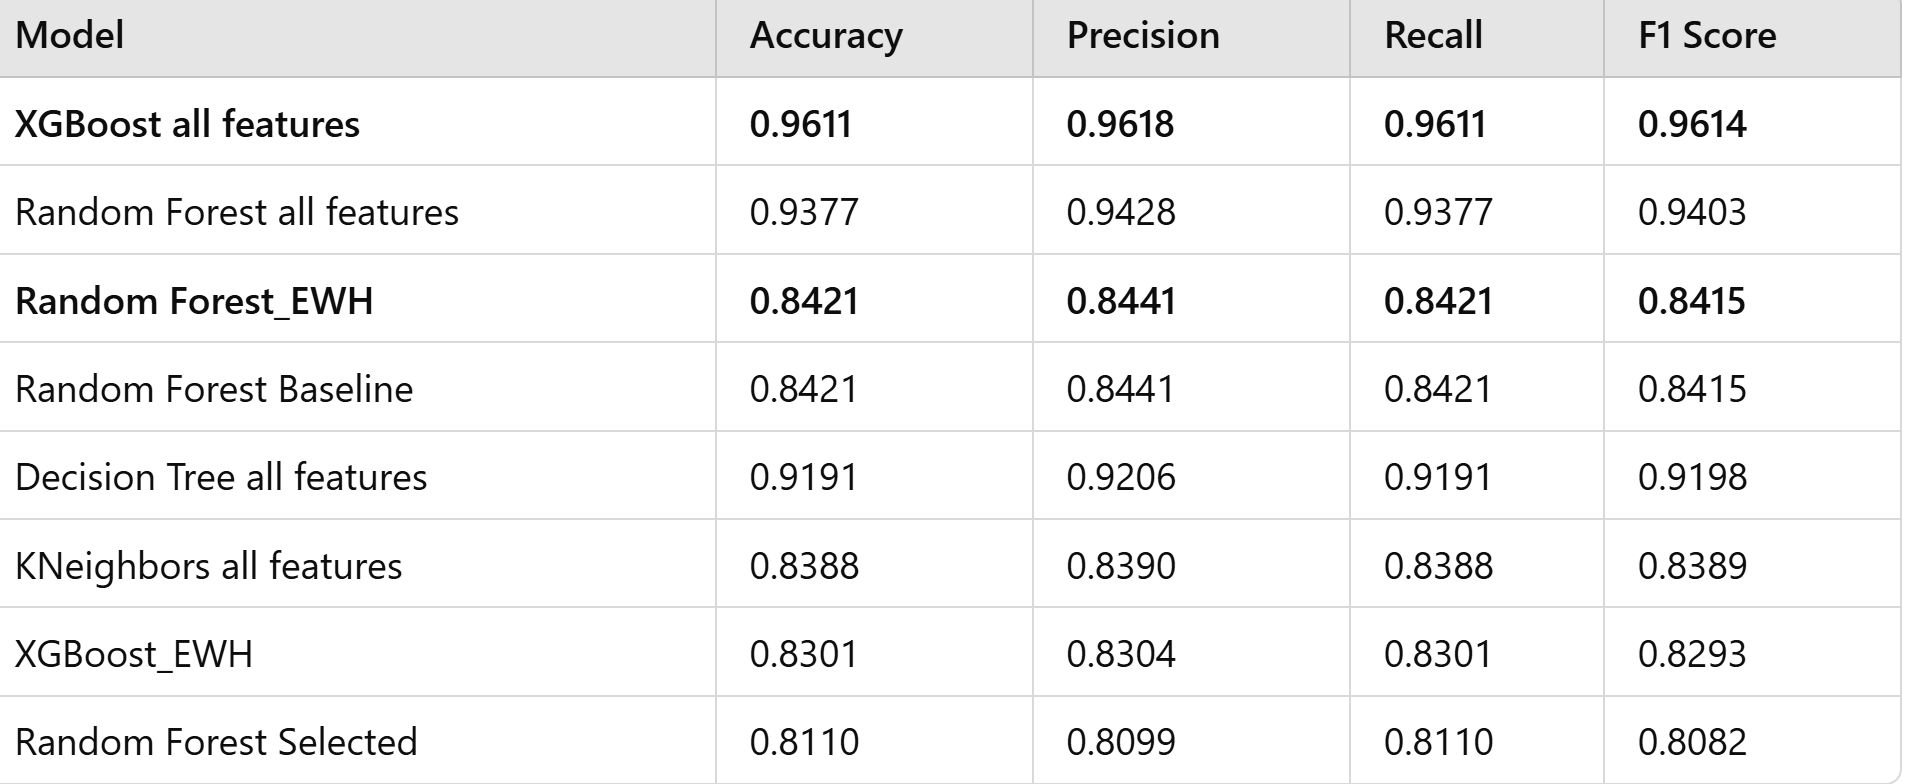